In [1]:
import pandas as pd
import numpy as np
import os,glob
from matplotlib import pyplot as plt

In [2]:
def modify_topics(t):
    ''' 
    Create a field/column with a list of the topics for that talk
    
    Modify the topics csv so that the title of the Talk will be split into the appropriate dates
    
    create a one hot encoding for the topics
    - so it becomes easy to search for specific topics, or topics for specific speakers
    '''
    # just remove the NaN 
    # topics_columns = t.fillna(0).iloc[:,range(1,24)].values
    topics_columns = t.fillna(0).iloc[:,1:].values
    topics_columns = [[x for x in row if x != 0] for row in topics_columns]
    t['topic_lists'] = topics_columns
    
    colon = np.array([x[-8] == ':' for x in t[t.columns[0]]])
    assert (colon.astype(int).sum() / t.shape[0]) == 1.0,'there are places where the colon isnt the -8th element in string'
    t['Title'] = [x[:-8] for x in t[t.columns[0]]]
    t['Year'] = [int(x[-7:-3]) for x in t[t.columns[0]]]
    t['Month'] = [int(x[-2:]) for x in t[t.columns[0]]]
    
    #create one hot encoding for topics
    # this was a really fast process
    all_topics = set()
    for i in range(0,23):
        all_topics = all_topics.union(set(t[str(i)].unique()))
    #print(len(all_topics))
    all_topics.remove(np.nan)
    #print(len(all_topics))
    z = np.zeros((t.shape[0],len(all_topics)))
    Z = pd.DataFrame(z,columns = sorted(list(all_topics)))
    #print(t.shape,Z.shape)
    t = pd.concat([t,Z],axis=1)
    #print(t.shape)
    
    # my algorithm for the one hot encoding will be to iterate through the rows, 
    #an for the list of topics for that row to add one in the appropriate column
    # this ran in just a few seconds
    column_names = list(t.columns)
    for i in range(t.shape[0]):
        individual_topics = t.iloc[i]['topic_lists']
        for topic in individual_topics:
            t.iloc[i,column_names.index(topic)] += 1
            
    #note that temples and temple have the exact same talks associated, so it's useless to keep both
    t.drop(columns='temples',inplace=True)
            
    return t
    

In [3]:
def cols(temp):
    l = [x for x in temp.columns]
    print(l)

In [4]:
#t for topics
t = pd.read_csv('data/topic_data.csv')
print(t.shape)
print(t.columns)
t = modify_topics(t)
print('t shape after one hot encoding topics',t.shape)
# t.tail(10)

(3692, 24)
Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype='object')
t shape after one hot encoding topics (3692, 326)


In [5]:
#s for summary
s = pd.read_csv('summary2.csv',index_col=0)
print(s.shape)
s.rename(columns={'Month':'Month_letter'},inplace=True)
print(s.columns)
s['Month'] = s['Month_letter'].map({'A':4,'O':10})

(5365, 6)
Index(['Year', 'Month_letter', 'Speaker', 'Title', 'File', 'Kicker'], dtype='object')


In [6]:
#s for summary
# s2 = pd.read_csv('data/wrongsummary.csv',index_col=0)
# print(s2.shape)
# s2.rename(columns={'Month':'Month_letter'},inplace=True)
# print(s2.columns)
# s2['Month'] = s2['Month_letter'].map({'A':4,'O':10})

In [7]:
# s2.equals(s)

In [8]:
#check to se if the talk by elder eyring "try,try,try" appears as such instead of "try"
# s.loc[(s.Year == 2018) & (s.Month == 10)]

In [9]:
s.Year.min(),t.Year.min()

(1942, 1971)

In [10]:
#drop the columns where s is less than 1971 to prep for merge between s and t
s.drop(index=s.loc[s.Year < 1971].index,inplace=True)
t.drop(columns=[str(x) for x in range(23)],inplace=True)

In [11]:
print('t.shape',t.shape,'s.shape',s.shape)
new = s.merge(t,how='inner',left_on=['Title','Year','Month'],right_on=['Title','Year','Month'])
print(new.shape)

t.shape (3692, 303) s.shape (3542, 7)
(3465, 307)


# there would be 303 + 7 = 310 columns but there are 3 columns repeated
so 310 - 3 = 307 columns makes sense

In [12]:
# new.loc[(new.Year == 2018) & (new.Month == 10) & (new.Speaker == 'Henry B. Eyring')]

In [13]:
new.to_csv('merged_summary_topics.csv',index=False)

In [14]:
new2 = pd.read_csv('merged_summary_topics.csv')

In [15]:
# new2.loc[(new2.Year == 2018) & (new2.Month == 10) & (new2.Speaker == 'Henry B. Eyring')]

In [16]:
new.equals(new2)

False

In [17]:
new2.shape

(3465, 307)

In [18]:
new.Speaker.value_counts().iloc[:20]

Thomas S. Monson      207
Gordon B. Hinckley    207
James E. Faust         97
Boyd K. Packer         86
L. Tom Perry           85
Henry B. Eyring        85
M. Russell Ballard     78
Russell M. Nelson      77
Dallin H. Oaks         73
Spencer W. Kimball     69
Ezra Taft Benson       60
Richard G. Scott       59
David B. Haight        59
Dieter F. Uchtdorf     59
Robert D. Hales        58
Marion G. Romney       57
Joseph B. Wirthlin     53
Howard W. Hunter       51
Jeffrey R. Holland     51
Neal A. Maxwell        50
Name: Speaker, dtype: int64

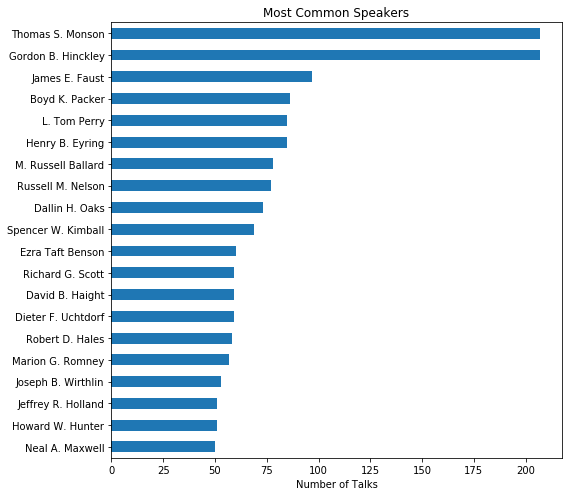

In [19]:
x = new.Speaker.value_counts().iloc[:20]
x.sort_values(ascending=True,inplace=True)

fig = plt.figure(figsize=(4*2,7))
x.plot(kind='barh')
plt.xlabel('Number of Talks')
plt.title('Most Common Speakers')
plt.savefig('Most Common Speakers.png',dpi=300)
plt.tight_layout()
plt.show()

In [20]:
def most_common_talks(speaker):
    y = new.loc[new.Speaker == speaker]
    # the topics are the 9th column and on
    z = y.iloc[:,9:]
    tcounts = z.sum()
    tcounts.sort_values(ascending=False,inplace=True)
    fig = plt.figure(figsize=(5,7))
    temp = tcounts.head(20)
    temp.sort_values(ascending=True,inplace=True)
    temp.plot(kind='barh')
    plt.title(f'Most Common Topics for {speaker}')
    plt.show()

In [21]:
new.Speaker.value_counts().iloc[:20]

Thomas S. Monson      207
Gordon B. Hinckley    207
James E. Faust         97
Boyd K. Packer         86
L. Tom Perry           85
Henry B. Eyring        85
M. Russell Ballard     78
Russell M. Nelson      77
Dallin H. Oaks         73
Spencer W. Kimball     69
Ezra Taft Benson       60
Richard G. Scott       59
David B. Haight        59
Dieter F. Uchtdorf     59
Robert D. Hales        58
Marion G. Romney       57
Joseph B. Wirthlin     53
Howard W. Hunter       51
Jeffrey R. Holland     51
Neal A. Maxwell        50
Name: Speaker, dtype: int64

In [22]:
# most_common_talks('Thomas S. Monson')

In [23]:
# most_common_talks('Russell M. Nelson')

In [24]:
def plot_two_speaker_topics(list_speakers,figure_title):
    
    fig,ax = plt.subplots(1,2,figsize=(4*2,4*2))
    speaker = list_speakers[0]
    y = new.loc[new.Speaker == speaker]
    # the topics are the 9th column and on
    z = y.iloc[:,9:]
    tcounts = z.sum()
    tcounts.sort_values(ascending=False,inplace=True)
    temp = tcounts.head(20)
    temp.sort_values(ascending=True,inplace=True)
    temp.plot(kind='barh',ax=ax[0])
    ax[0].set_title(f'Most Common Topics for\n{speaker}')

    speaker = list_speakers[1]
    y = new.loc[new.Speaker == speaker]
    # the topics are the 9th column and on
    z = y.iloc[:,9:]
    tcounts = z.sum()
    tcounts.sort_values(ascending=False,inplace=True)
    temp = tcounts.head(20)
    temp.sort_values(ascending=True,inplace=True)
    temp.plot(kind='barh',ax=ax[1])
    ax[1].set_title(f'Most Common Topics for\n{speaker}')

    plt.tight_layout()
    plt.savefig(figure_title,dpi=300)
    plt.show()

In [25]:
os.listdir()

['topic_count.csv',
 '.DS_Store',
 'merged_summary_topics.csv',
 'gencon-nlp',
 'web',
 'Most Common Speakers.png',
 'data2.zip',
 'merge topic & summary.ipynb',
 'Monson_Nelson_most_common_talks.png',
 'delete.png',
 'summary2.csv',
 '.ipynb_checkpoints',
 'data',
 'Holland_Uchtdorf_most_common_talks.png']

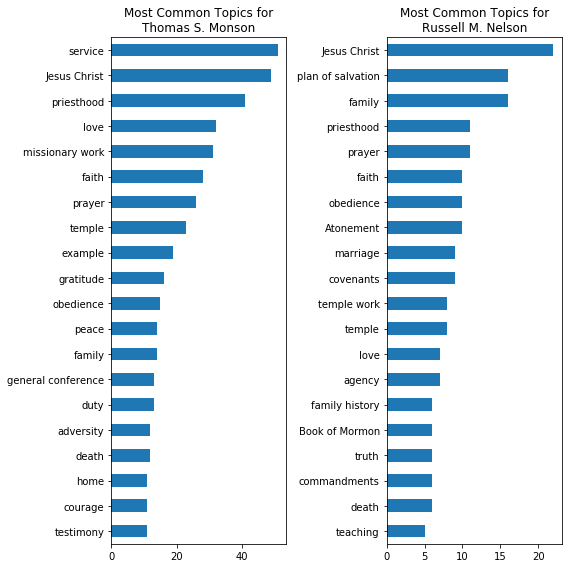

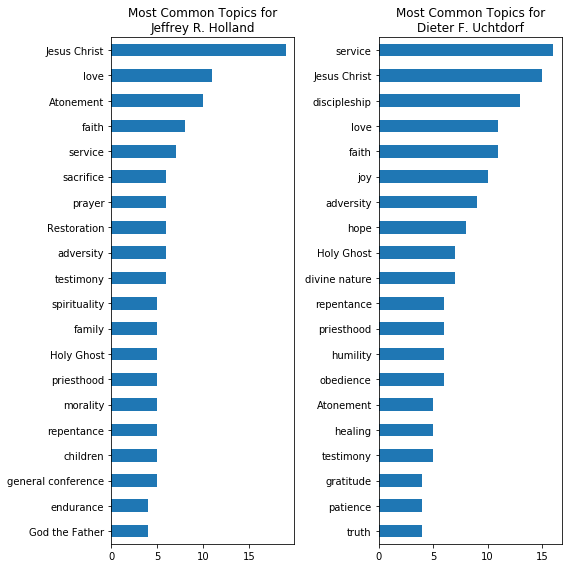

In [26]:
plot_two_speaker_topics(['Thomas S. Monson','Russell M. Nelson'],'Monson_Nelson_most_common_talks.png')
plot_two_speaker_topics(['Jeffrey R. Holland','Dieter F. Uchtdorf'],'Holland_Uchtdorf_most_common_talks.png')

# look at some individual talks and the topics for that talk

In [30]:
# dict(new.Speaker.value_counts())

In [28]:
# I recently just listened to a talk by Elder Christofferson called "when thou art converted"
keep = ['Year','Month_letter','Month','Title','topic_lists']
new.loc[(new.Speaker == 'D. Todd Christofferson')][keep].sort_values(by=['Year','Month']
                                                                     ,ascending=[False,True],inplace=False)

,Year,Month_letter,Month,Title,topic_lists
3411,2018,A,4,The Elders Quorum,"[Melchizedek Priesthood, ministering, priestho..."
3439,2018,O,10,Firm and Steadfast in the Faith of Christ,"[Jesus Christ, faith, adversity, conversion, c..."
3355,2017,A,4,The Voice of Warning,"[Jesus Christ, prophets, parenthood, standards..."
3370,2017,O,10,The Living Bread Which Came Down from Heaven,"[Jesus Christ, holiness, repentance, service, ..."
3279,2016,A,4,Fathers,"[discipline, example, education, marriage, lov..."
3302,2016,O,10,“Abide in My Love”,"[Jesus Christ, divine nature, repentance, obed..."
3190,2015,A,4,"Why Marriage, Why Family","[Creation, Fall, Atonement, marriage, plan of ..."
3246,2015,O,10,Why the Church,"[Church organization, priesthood, Church meeti..."
3135,2014,A,4,The Resurrection of Jesus Christ,"[Jesus Christ, justice, Resurrection, Atonement]"
3146,2014,O,10,"Free Forever, to Act for Themselves","[Jesus Christ, mercy, truth, justice, repentan..."


In [29]:
index_ = 2373
print(new.iloc[index_,:9])
# print('\n\n',new.iloc[index_,:9].Title)
print('\n\n',new.iloc[index_,:9].Kicker)
new.iloc[index_,:9].topic_lists

Year                                                         2004
Month_letter                                                    A
Speaker                                    D. Todd Christofferson
Title                                     When Thou Art Converted
File                                                data/6953.txt
Kicker          Plead with God in the name of Christ to write ...
Month                                                           4
Unnamed: 0                        When Thou Art Converted:2004/04
topic_lists     [prayer, repentance, scripture study, conversion]
Name: 2373, dtype: object


 Plead with God in the name of Christ to write the gospel in your mind that you may have understanding and in your heart that you may love to do His will.


['prayer', 'repentance', 'scripture study', 'conversion']